# Titanic Analysis
## Data Processing

In [111]:
# Notice: have not done:
    #scaling
    #examine the cov between features
    #categorical to binary: https://stackoverflow.com/questions/32387266/converting-categorical-values-to-binary-using-pandas
    #also change test data
    

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import style  
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from operator import itemgetter
import re
import warnings
warnings.filterwarnings("ignore")

style.use('seaborn')      
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['axes.unicode_minus'] = False  

In [113]:
# Load dataset and view the table
titanic = pd.read_csv("titanic_train.csv")
titanic.head(5).style

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,nan,S


In [114]:
# Examine the data
titanic.describe().style

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891,891,891,714,891,891,891
mean,446,0.383838,2.30864,29.6991,0.523008,0.381594,32.2042
std,257.354,0.486592,0.836071,14.5265,1.10274,0.806057,49.6934
min,1,0,1,0.42,0,0,0
25%,223.5,0,2,20.125,0,0,7.9104
50%,446,0,3,28,0,0,14.4542
75%,668.5,1,3,38,1,0,31
max,891,1,3,80,8,6,512.329


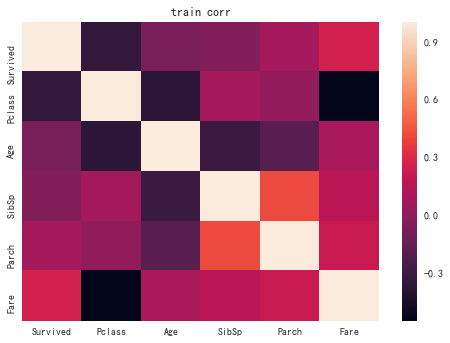

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


In [115]:
#Correlation among variables#
data=titanic[['Survived','Pclass','Age','SibSp','Parch','Fare','Sex']]
data=data.corr()
sns.heatmap(data)
plt.title('train corr')
plt.show()                   
print(data)

In [116]:
titanic.info() #check missing values#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [117]:
titanic[titanic['Embarked'].isnull()] #check other information of passengers whoes embarked lost#

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


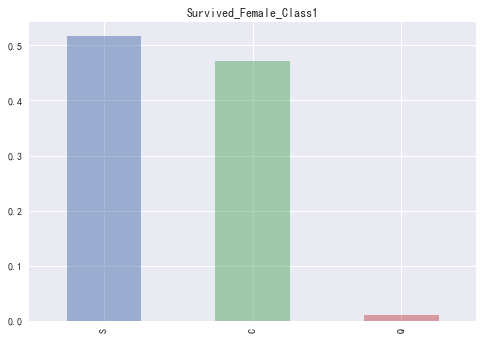

In [118]:
titanic.Embarked[(titanic.Sex=='female')&(titanic.Pclass==1)&(titanic.Survived==1)].value_counts(normalize=True).plot(kind="bar", alpha=0.5)
plt.title('Survived_Female_Class1')
plt.show()
#the plot shows that s has highest probability#

In [119]:
#missing value replacement#
#Embarked---replace missing value. the above two passengers have some common features:female,survived,class1#
titanic[titanic['Embarked'].isnull()]
titanic.Embarked[titanic.Embarked.isnull()]=titanic['Embarked'].fillna('S')

#Cabin#
titanic['Cabin'] = titanic.Cabin.fillna('U0')
# too many missing values, mode,median,mean are useless here.so we replace them by u0


In [120]:
#Age--replace missing value by RFR

# Get the title from the names
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
    
# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Capt          1
Jonkheer      1
Sir           1
Lady          1
Mme           1
Countess      1
Don           1
Ms            1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [121]:
#choose training data to predict age
age_titanic = titanic[['Age','Fare', 'Parch','SibSp','Parch','Title']] #select related variables put into the model
age_titanic_notnull = age_titanic.loc[(titanic['Age'].notnull())] # select nonnull 
age_titanic_isnull = age_titanic.loc[(titanic['Age'].isnull())]
X = age_titanic_notnull.values[:,1:] #set 'Fare', 'Parch','SibSp','Parch','Title' as X#
Y = age_titanic_notnull.values[:,0] # set the first colume 'age' as Y#

# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1) 
#n_estimators : The number of trees in the forest b.
#n_jobs: The number of jobs to run in parallel for both fit and predict.-1 means using all processors. 

RFR.fit(X,Y) #prediction
predictAges = RFR.predict(age_titanic_isnull.values[:,1:])
titanic.loc[titanic['Age'].isnull(), ['Age']]= predictAges
predictAges

array([23.76667828, 31.54506842, 33.07624167, 32.56895574, 21.58312262,
       27.87124071, 28.30258667, 26.20365046, 24.8111003 , 27.87124071,
       30.80973483, 33.6551381 , 26.20365046, 26.027175  , 39.51210952,
       36.61538976,  5.53194024, 27.87124071, 30.80973483, 21.85069919,
       30.80973483, 30.80973483, 27.87124071, 29.57015787, 26.62976442,
       30.80973483, 41.84428707,  5.71258393, 27.98      , 30.75438621,
       25.64179036,  8.01154159, 42.17101667, 41.3877937 ,  5.93494802,
       15.54133492, 28.89805833, 58.6795    , 30.54633333, 41.84428707,
       26.20365046, 16.45931706, 33.75736048, 27.87124071,  6.8921631 ,
       21.5654246 , 17.57454526, 23.63607383, 30.75438621, 51.07061905,
       41.84428707, 26.20365046, 43.64861667, 26.20365046, 34.47765559,
       39.93677169, 36.61538976, 42.00221905, 26.20365046, 24.89578095,
       25.69963921, 30.80973483, 29.00071667, 16.45931706, 23.11164959,
       25.60433333, 27.87124071, 27.2776    , 57.92305   , 32.56

In [122]:
titanic.info() #check whether imputation is successful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [123]:
print(titanic["Sex"].unique()) # view

titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

print(titanic["Sex"].unique()) # check

['male' 'female']
[0 1]


In [124]:
    # Replace Embarked label "S" with 0, "C" with 1, "Q" with 2

print(titanic["Embarked"].unique())

titanic["Embarked"] = titanic["Embarked"].fillna('S')
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

print(titanic["Embarked"].unique())

['S' 'C' 'Q']
[0 1 2]


In [125]:
type(titanic)

pandas.core.frame.DataFrame

In [126]:
# Prepare to test
    # Preprocess the testing datasets (just as what we did previously)
titanic_test = pd.read_csv("test.csv")
# titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())

# Get all the titles and print how often each one occurs.
titles = titanic_test["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Dona":8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
    
# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic_test["Title"] = titles

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Name, dtype: int64
1    240
2     79
3     72
4     21
7      2
6      2
8      1
5      1
Name: Name, dtype: int64


In [127]:
#Test set--missing value#
#Fare#
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
#Embarked#
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("Q")
#cabin#
titanic_test['Cabin'] = titanic_test.Cabin.fillna('U0')


#choose testing data to predict age
age_test = titanic_test[['Age','Fare', 'Parch','SibSp','Parch','Title']]

age_test_notnull = age_test[age_test['Age'].notnull()]
age_test_isnull = age_test[(age_test['Age'].isnull())]

X = age_test_notnull.values[:,1:]
Y = age_test_notnull.values[:,0]


# use RandomForestRegression to test data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predict_test_Ages = RFR.predict(age_test_isnull.values[:,1:])
titanic_test.loc[titanic_test['Age'].isnull(), ['Age']]= predict_test_Ages
predict_test_Ages

In [ ]:
titanic_test.info()

In [18]:
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

## Feature Engineering

In [20]:
full_dataset = [titanic, titanic_test]

In [297]:
# Generating age group
for dataset in full_dataset:    
    dataset.loc[dataset["Age"] <= 14, "AgeC"] = 0
    dataset.loc[(dataset["Age"] > 14) & (dataset["Age"] <= 34), "AgeC"] = 1
    dataset.loc[(dataset["Age"] > 34) & (dataset["Age"] <= 53), "AgeC"] = 2
    dataset.loc[dataset["Age"] > 53, "AgeC"] = 3
    
# Generating familysize
for dataset in full_dataset:  
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"]

# Generating traveling alone
for dataset in full_dataset:   
    dataset["Alone"] = 0
    dataset.loc[dataset["FamilySize"] == 0, "Alone"] = 1

# Get the title from the names
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 4, "Rev": 4, "Major": 4, "Col": 4, "Mlle": 4, "Mme": 4, "Don": 4, "Lady": 4, "Countess": 4, "Jonkheer": 4, "Sir": 4, "Capt": 4, "Ms": 4}
    
# Generating Title
for dataset in full_dataset: 
    dataset["Title"] = dataset["Name"].apply(get_title)
    for k,v in title_mapping.items():
        dataset.loc[dataset["Title"] == k, "Title"] = v
          
# Generating Name Length
for dataset in full_dataset: 
    dataset["NameLength"] = dataset["Name"].apply(lambda x: len(x))

In [326]:
# Generating Price Range
for dataset in full_dataset:    
    dataset.loc[dataset["Fare"] <= 7.9, "FareC"] = 0
    dataset.loc[(dataset["Fare"] > 7.9) & (dataset["Fare"] <= 14.5), "FareC"] = 1
    dataset.loc[(dataset["Fare"] > 14.5) & (dataset["Fare"] <= 31), "FareC"] = 2
    dataset.loc[dataset["Fare"] > 31, "FareC"] = 3

# Generating Has Cabin
for dataset in full_dataset:
    dataset["NoCabin"] = pd.isna(dataset["Cabin"])

# Generating Position
# Map each Position to an integer.
position_mapping = {"0": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
        
for dataset in full_dataset:
    dataset["Position"] = dataset["Cabin"].str[0]
    dataset["Position"].fillna("0", inplace=True)
    dataset["Position"] = dataset["Position"].astype(str)
    for k,v in position_mapping.items():
        dataset.loc[dataset["Position"] == k, "Position"] = v

# Generating Pair
def NumberFromStrings(string):
    numberfromstring = re.findall('\d+',string)
    if numberfromstring == []:
        return int(0)
    else:
        return int(numberfromstring[0])

# This method considers cabin without numbers, f.ex. "F", as being even number rooms.
for dataset in full_dataset: 
    dataset["Pair"] = dataset["Cabin"].astype(str)
    dataset["Pair"] = dataset["Pair"].apply(NumberFromStrings)
    dataset["Pair"] = dataset["Pair"] % 2
    dataset.loc[pd.isna(dataset["Cabin"]), "Pair"] = -1

/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1164: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


TypeError: invalid type comparison

In [321]:
titanic.Position.unique()

array(['0', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [323]:
df = pd.DataFrame({'col2': {0: 'a', 1: 2, 2: np.nan}, 'col1': {0: 'w', 1: 'A', 2: 'B'}})
di = {"B": 2, "A": 1}
print(df)
print(df.replace({"col1": di}))


  col2 col1
0    a    w
1    2    A
2  NaN    B
  col2 col1
0    a    w
1    2    1
2  NaN    2


## Feature Scalling

Here, all studied variables are categorical or of small scale (number of siblings or length of name). We do not need to perform feature scalling

## Transforming  To Categorical Variables

In [281]:
titanic.Position.unique()

array([0, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

## Dimensionality Reduction

## Learning Algorithm

In [279]:
predictors = ["Pclass", "Sex", "AgeC", "SibSp", "Parch", "FamilySize", "Alone", "FareC", "Embarked", "Title", "NameLength", "NoCabin", "Position", "Pair"] # renew the predict

In [280]:
# Perform feature selection: f_classif
X, y = (titanic[predictors], titanic["Survived"])
selector = SelectKBest(f_classif, k=4)
selector.fit(X,y)

X_new = selector.transform(X)
X_new.shape

print("Under f_classif selection, the best 4 features is:{}".format(X.columns[selector.get_support(indices=True)].tolist()))


ValueError: could not convert string to float: 'C'

In [19]:
# Perform feature selection: chi2

selector = SelectKBest(chi2, k=4)
selector.fit(X,y)

X_new = selector.transform(X)
X_new.shape

print("Under chi2 selection,the best 4 features is:{}".format(X.columns[selector.get_support(indices=True)].tolist()))


Under chi2 selection,the best 4 features is:['Sex', 'Fare', 'Title', 'NameLength']


In [20]:
# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

C:\Users\j\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


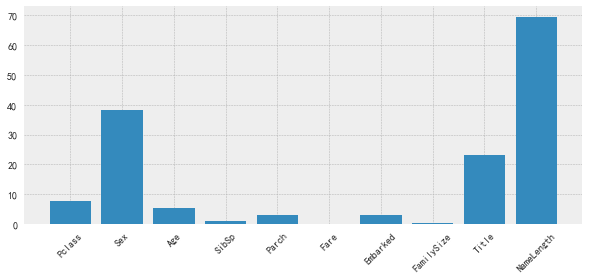

In [21]:
# Plot the scores.  We can also see the "Pclass", "Sex", "Title", and "Fare" are the best
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "NameLength"] # renew the predictors
plt.figure(figsize=(10, 4))
plt.style.use('bmh')
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation=45)
plt.show()

In [22]:
# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]
alg = RandomForestClassifier(random_state=1, n_estimators=49, min_samples_split=4, min_samples_leaf=2)
# Compute the accuracy score
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=4)

print("With 4 best features and under RandomForest Regression of 4 folds, the scores of the Cross Validation is:", scores.mean())

With 4 best features and under RandomForest Regression of 4 folds, the scores of the Cross Validation is: 0.8126165533326407


In [ ]:
# Trial Comparison of different combinations of the parameters
from tqdm import tqdm
score = []

for i in tqdm(range(2,10)):
    for j in range(1,5):
        for g in range(2,7):
            for e in range(1,50):
                alg = RandomForestClassifier(random_state=1, n_estimators=e, min_samples_split=i, min_samples_leaf=j)
                # Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
                scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=g)
                # Take the mean of the scores (because we have one for each fold)
                score.append([[e,i,j,g],scores.mean()])

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

In [ ]:
# Sort the selection of parameters according to Accuracy score
score.sort(key = itemgetter(1),reverse=0)
score_top10 = score[-10:]
sc=np.array(score_top10)[:,-1]
para=np.array(score_top10)[:,0]
para = [str(x) for x in para]

# 2 ways of visulization plot
plt.figure(figsize=(10, 4))  
plt.xticks(rotation=30) 
plt.plot(para,sc)
plt.title('Accuracy_score under different parameters') 

In [ ]:
sns.barplot(sc,para)
plt.xlim([0.832,0.84])  
plt.title('Accuracy_score under different parameters') 